In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from gp_trajectory_compensation import TrajectoryCompensatorGP
from typing import Optional

In [2]:
# Load observed data (units: mm for distance, ms for time)
observed_df = pd.read_csv('experiment_2.csv')
t_sec_ms = observed_df['Time'].values  # Time in milliseconds
t_sec = t_sec_ms / 1000  # Convert to seconds for interpolation and GP
observed_xyz = observed_df[['x', 'y', 'z']].values  # Distance in mm
#T = observed_xyz.shape[0]  # Number of time points in observed data

In [3]:
# Commanded waypoints (units: mm)
x_cmd = np.array([-96.839, -58.761, -20.692, 17.378, 55.433, 93.495, 131.553])
y_cmd = np.array([79.866, 79.841, 79.816, 79.791, 79.776, 79.751, 79.726])
z_cmd = np.array([2.91, 3.00, 3.05, 2.95, 2.85, 2.87, 2.89])

# Time vector for waypoints (units: seconds)
t_waypoints = np.linspace(0, 7, 7)  # 7 seconds total

# Interpolate commanded trajectory (output: mm)
x_interp = interp1d(t_waypoints, x_cmd, kind='linear', fill_value='extrapolate')
y_interp = interp1d(t_waypoints, y_cmd, kind='linear', fill_value='extrapolate')
z_interp = interp1d(t_waypoints, z_cmd, kind='linear', fill_value='extrapolate')

# Create commanded_xyz (units: mm)
commanded_xyz = np.column_stack([
    x_interp(t_sec),  # Time in seconds, output in mm
    y_interp(t_sec),
    z_interp(t_sec)
])

In [4]:
# Desired trajectory (units: mm)
x_desired = np.linspace(0, 300, len(t_sec))  # Linear from 0 to 300 mm
y_desired = np.full(len(t_sec), 900)         # Constant at 900 mm
z_desired = np.full(len(t_sec), 800)         # Constant at 800 mm
desired_xyz = np.column_stack([x_desired, y_desired, z_desired])


In [5]:
# --- Sanity check: All arrays should be (T, 3) ---
print("desired_xyz shape:", desired_xyz.shape)
print("commanded_xyz shape:", commanded_xyz.shape)
print("observed_xyz shape:", observed_xyz.shape)
print("t_sec shape:", t_sec.shape)

desired_xyz shape: (7810, 3)
commanded_xyz shape: (7810, 3)
observed_xyz shape: (7810, 3)
t_sec shape: (7810,)


In [6]:
# Downsample to 20,000 points

# step = len(t_sec) // 20000
# t_sec_ds = t_sec[::step]
# desired_xyz_ds = desired_xyz[::step]
# commanded_xyz_ds = commanded_xyz[::step]
# observed_xyz_ds = observed_xyz[::step]

In [6]:
# Train the GP (time in seconds, distance in mm)
comp = TrajectoryCompensatorGP(include_vel=True, dt_hint=0.001, kernel='tiny', damping=1.0)
comp.fit(desired_xyz, commanded_xyz, observed_xyz, t_sec)

In [7]:
# Predict and compensate (output: mm)
predicted_error = comp.predict_error(commanded_xyz, desired_xyz, t_sec)
compensated_cmd = comp.compensate(desired_xyz, t_sec=t_sec, n_iter=3)

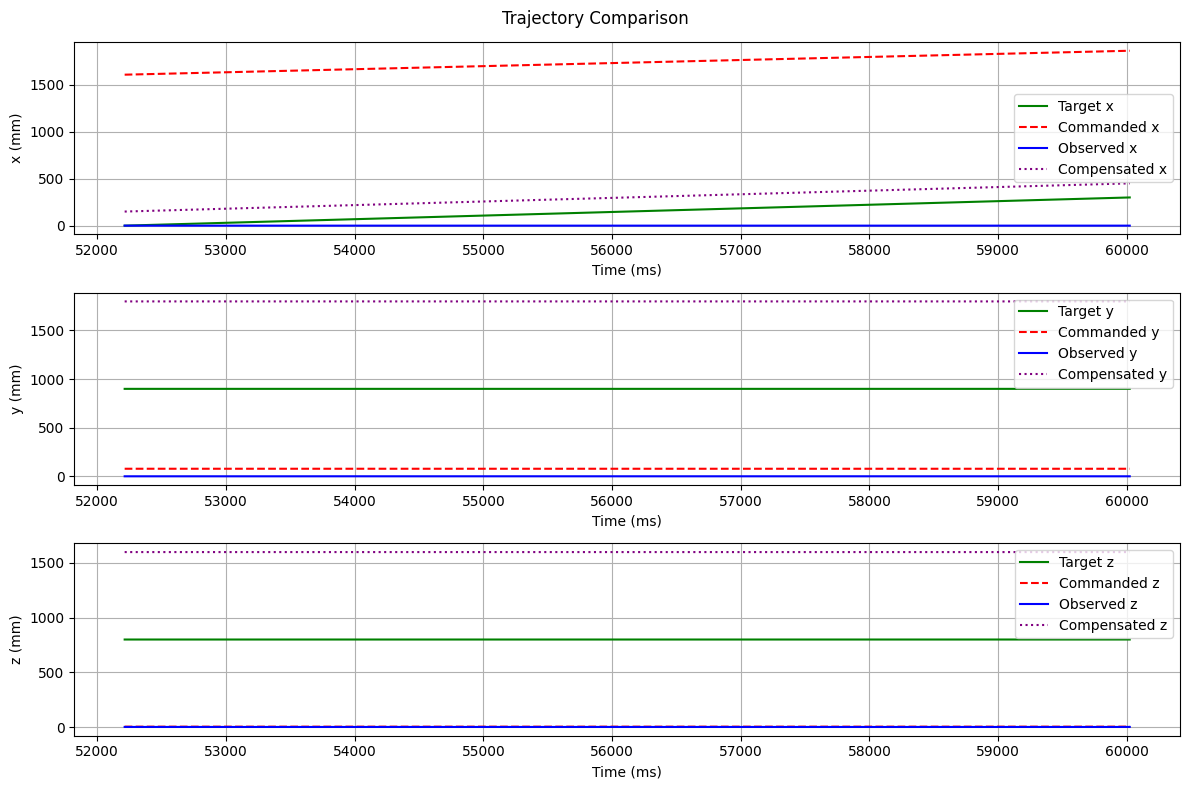

In [ ]:
# --- Plot trajectories ---
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
axes[0].plot(t_sec_ms, desired_xyz[:, 0], label='Target x', color='green')
axes[0].plot(t_sec_ms, commanded_xyz[:, 0], label='Commanded x', color='red', linestyle='--')
axes[0].plot(t_sec_ms, observed_xyz[:, 0], label='Observed x', color='blue')
axes[0].plot(t_sec_ms, compensated_cmd[:, 0], label='Compensated x', color='purple', linestyle=':')
axes[0].set_ylabel('x (mm)')
axes[0].legend()
axes[0].grid(True)
axes[0].tick_params(labelbottom=True)  # Show x-axis labels
axes[0].set_xlabel('Time (ms)')  # Add x-axis label

axes[1].plot(t_sec_ms, desired_xyz[:, 1], label='Target y', color='green')
axes[1].plot(t_sec_ms, commanded_xyz[:, 1], label='Commanded y', color='red', linestyle='--')
axes[1].plot(t_sec_ms, observed_xyz[:, 1], label='Observed y', color='blue')
axes[1].plot(t_sec_ms, compensated_cmd[:, 1], label='Compensated y', color='purple', linestyle=':')
axes[1].set_ylabel('y (mm)')
axes[1].legend()
axes[1].grid(True)
axes[1].tick_params(labelbottom=True)  # Show x-axis labels
axes[1].set_xlabel('Time (ms)')  # Add x-axis label

axes[2].plot(t_sec_ms, desired_xyz[:, 2], label='Target z', color='green')
axes[2].plot(t_sec_ms, commanded_xyz[:, 2], label='Commanded z', color='red', linestyle='--')
axes[2].plot(t_sec_ms, observed_xyz[:, 2], label='Observed z', color='blue')
axes[2].plot(t_sec_ms, compensated_cmd[:, 2], label='Compensated z', color='purple', linestyle=':')
axes[2].set_ylabel('z (mm)')
axes[2].set_xlabel('Time (ms)')
axes[2].legend()
axes[2].grid(True)

plt.suptitle('Trajectory Comparison')
plt.tight_layout()
plt.show()

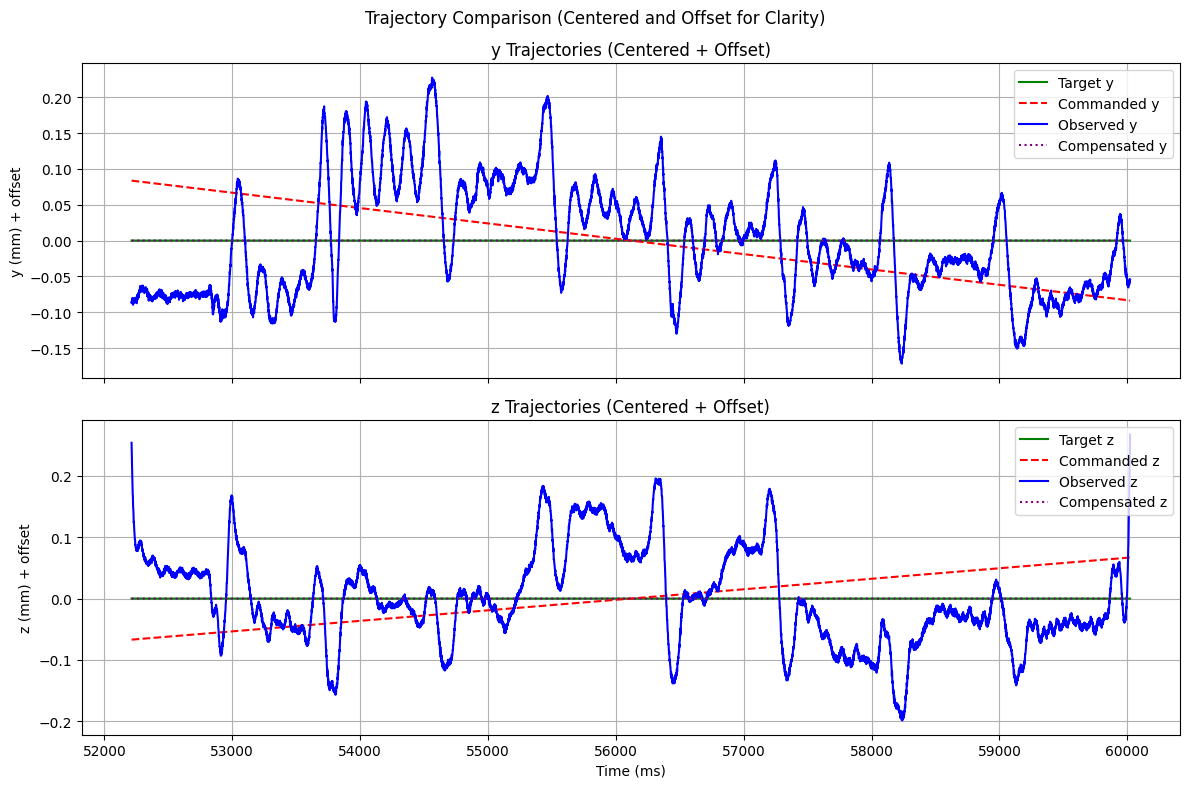

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Center trajectories around zero
mean_y_target = desired_xyz[:, 1].mean()
mean_y_cmd = commanded_xyz[:, 1].mean()
mean_y_obs = observed_xyz[:, 1].mean()
mean_y_comp = compensated_cmd[:, 1].mean()

mean_z_target = desired_xyz[:, 2].mean()
mean_z_cmd = commanded_xyz[:, 2].mean()
mean_z_obs = observed_xyz[:, 2].mean()
mean_z_comp = compensated_cmd[:, 2].mean()

# Define larger offsets (e.g., 100 mm)
offsets_y = [0, 0, 0, 0]  # [target, commanded, observed, compensated]
offsets_z = [0, 0, 0, 0]

# Center and offset y trajectories
y_target_centered = desired_xyz[:, 1] - mean_y_target + offsets_y[0]
y_cmd_centered = commanded_xyz[:, 1] - mean_y_cmd + offsets_y[1]
y_obs_centered = observed_xyz[:, 1] - mean_y_obs + offsets_y[2]
y_comp_centered = compensated_cmd[:, 1] - mean_y_comp + offsets_y[3]

# Center and offset z trajectories
z_target_centered = desired_xyz[:, 2] - mean_z_target + offsets_z[0]
z_cmd_centered = commanded_xyz[:, 2] - mean_z_cmd + offsets_z[1]
z_obs_centered = observed_xyz[:, 2] - mean_z_obs + offsets_z[2]
z_comp_centered = compensated_cmd[:, 2] - mean_z_comp + offsets_z[3]

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# y trajectories
axes[0].plot(t_sec_ms, y_target_centered, label='Target y', color='green')
axes[0].plot(t_sec_ms, y_cmd_centered, label='Commanded y', color='red', linestyle='--')
axes[0].plot(t_sec_ms, y_obs_centered, label='Observed y', color='blue')
axes[0].plot(t_sec_ms, y_comp_centered, label='Compensated y', color='purple', linestyle=':')
axes[0].set_ylabel('y (mm) + offset')
axes[0].legend()
axes[0].grid(True)
axes[0].set_title('y Trajectories (Centered + Offset)')

# z trajectories
axes[1].plot(t_sec_ms, z_target_centered, label='Target z', color='green')
axes[1].plot(t_sec_ms, z_cmd_centered, label='Commanded z', color='red', linestyle='--')
axes[1].plot(t_sec_ms, z_obs_centered, label='Observed z', color='blue')
axes[1].plot(t_sec_ms, z_comp_centered, label='Compensated z', color='purple', linestyle=':')
axes[1].set_ylabel('z (mm) + offset')
axes[1].set_xlabel('Time (ms)')
axes[1].legend()
axes[1].grid(True)
axes[1].set_title('z Trajectories (Centered + Offset)')

plt.suptitle('Trajectory Comparison (Centered and Offset for Clarity)')
plt.tight_layout()
plt.show()


----------------------------------------

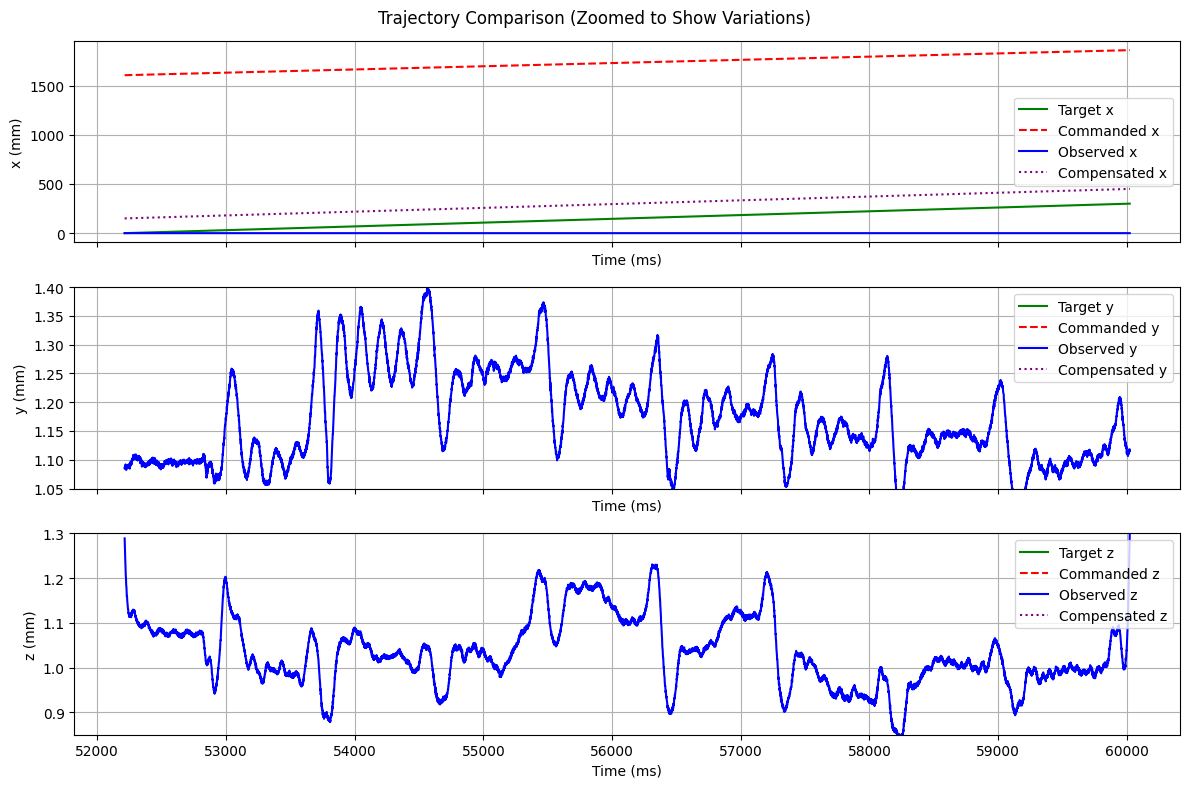

In [33]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# x-axis
axes[0].plot(t_sec_ms, desired_xyz[:, 0], label='Target x', color='green')
axes[0].plot(t_sec_ms, commanded_xyz[:, 0], label='Commanded x', color='red', linestyle='--')
axes[0].plot(t_sec_ms, observed_xyz[:, 0], label='Observed x', color='blue')
axes[0].plot(t_sec_ms, compensated_cmd[:, 0], label='Compensated x', color='purple', linestyle=':')
axes[0].set_ylabel('x (mm)')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Time (ms)')

# y-axis (zoomed)
axes[1].plot(t_sec_ms, desired_xyz[:, 1], label='Target y', color='green')
axes[1].plot(t_sec_ms, commanded_xyz[:, 1], label='Commanded y', color='red', linestyle='--')
axes[1].plot(t_sec_ms, observed_xyz[:, 1], label='Observed y', color='blue')
axes[1].plot(t_sec_ms, compensated_cmd[:, 1], label='Compensated y', color='purple', linestyle=':')
axes[1].set_ylabel('y (mm)')
axes[1].set_ylim(1.05, 1.4)  # Adjust based on your raw y data
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Time (ms)')

# z-axis (zoomed)
axes[2].plot(t_sec_ms, desired_xyz[:, 2], label='Target z', color='green')
axes[2].plot(t_sec_ms, commanded_xyz[:, 2], label='Commanded z', color='red', linestyle='--')
axes[2].plot(t_sec_ms, observed_xyz[:, 2], label='Observed z', color='blue')
axes[2].plot(t_sec_ms, compensated_cmd[:, 2], label='Compensated z', color='purple', linestyle=':')
axes[2].set_ylabel('z (mm)')
axes[2].set_ylim(0.85, 1.3)  # Adjust based on your raw z data
axes[2].set_xlabel('Time (ms)')
axes[2].legend()
axes[2].grid(True)

plt.suptitle('Trajectory Comparison (Zoomed to Show Variations)')
plt.tight_layout()
plt.show()


-----------------------------------------------

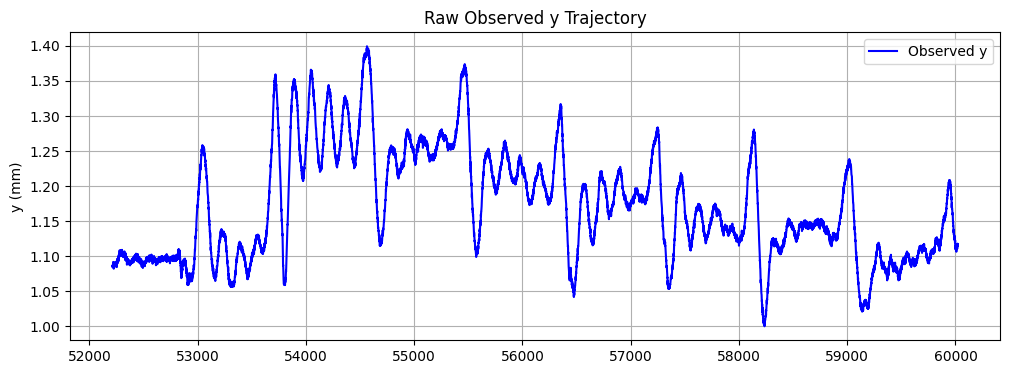

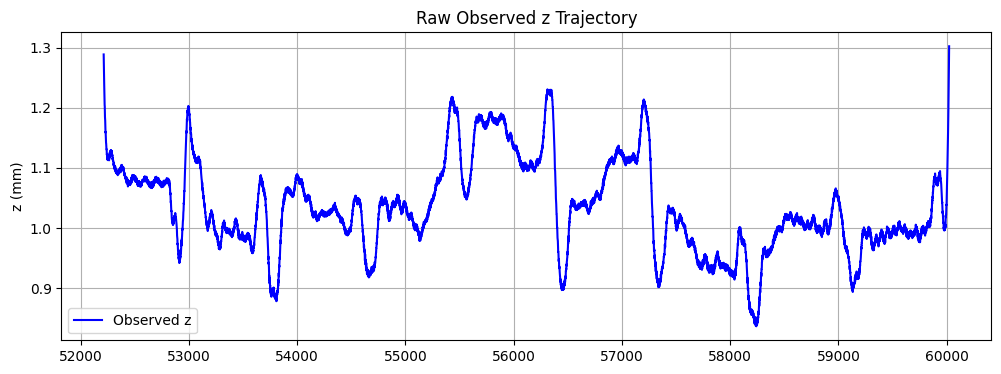

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(t_sec_ms, observed_xyz[:, 1], label='Observed y', color='blue')
plt.ylabel('y (mm)')
plt.grid(True)
plt.legend()
plt.title('Raw Observed y Trajectory')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(t_sec_ms, observed_xyz[:, 2], label='Observed z', color='blue')
plt.ylabel('z (mm)')
plt.grid(True)
plt.legend()
plt.title('Raw Observed z Trajectory')
plt.show()


------------------------------------------

In [28]:
def plot_compensation_process(
    comp: TrajectoryCompensatorGP,
    desired_xyz: np.ndarray,
    t_sec: np.ndarray,
    n_iter: int = 3,
    axis: int = 0,
    t_sec_ms: Optional[np.ndarray] = None,
):
    import matplotlib.pyplot as plt

    if t_sec_ms is None:
        t_sec_ms = t_sec * 1000  # convert to ms for plotting

    cmd = desired_xyz.copy()
    cmds = [cmd.copy()]
    errors = []

    # Store predicted error for initial command (Iter 0)
    pred_err = comp.predict_error(cmd, desired_xyz, t_sec)
    errors.append(pred_err.copy())

    for i in range(n_iter):
        cmd = desired_xyz - comp.damping * pred_err
        cmds.append(cmd.copy())
        pred_err = comp.predict_error(cmd, desired_xyz, t_sec)
        errors.append(pred_err.copy())

    # Plot commanded trajectory evolution
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Commanded trajectory
    for i, c in enumerate(cmds):
        label = f'Iter {i}' if i < n_iter else f'Iter {n_iter}'
        axes[0].plot(t_sec_ms, c[:, axis], label=label, linestyle='--' if i < n_iter else '-', linewidth=2 if i == n_iter else 1)
    axes[0].plot(t_sec_ms, desired_xyz[:, axis], label='Desired', color='green', linewidth=2)
    axes[0].set_ylabel(f'Commanded {["x", "y", "z"][axis]} (mm)')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_title(f'Evolution of Commanded Trajectory (axis {["x", "y", "z"][axis]})')

    # Predicted error
    for i, e in enumerate(errors):
        label = f'Iter {i}' if i < n_iter else f'Iter {n_iter}'
        axes[1].plot(t_sec_ms, e[:, axis], label=label, linestyle='--' if i < n_iter else '-', linewidth=2 if i == n_iter else 1)
    axes[1].set_ylabel(f'Predicted Error {["x", "y", "z"][axis]} (mm)')
    axes[1].set_xlabel('Time (ms)')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_title(f'Evolution of Predicted Error (axis {["x", "y", "z"][axis]})')

    plt.tight_layout()
    plt.show()


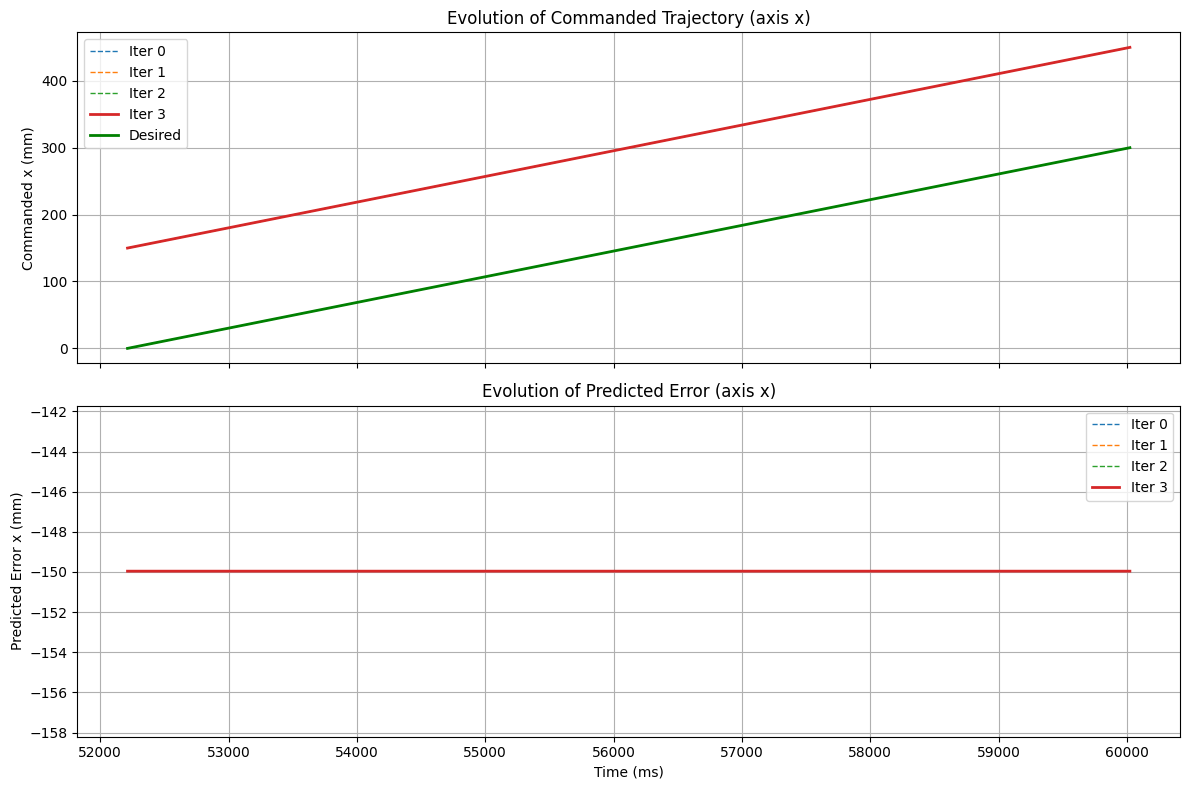

In [ ]:
plot_compensation_process(comp, desired_xyz, t_sec, n_iter=3, axis=0, t_sec_ms=t_sec_ms)


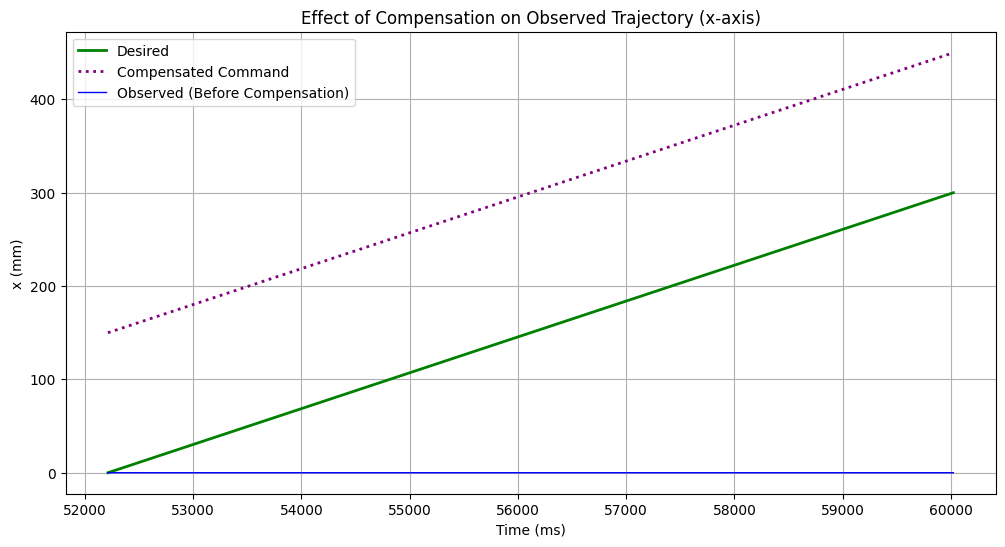

In [30]:
# After running compensation:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t_sec_ms, desired_xyz[:, 0], label='Desired', color='green', linewidth=2)
ax.plot(t_sec_ms, compensated_cmd[:, 0], label='Compensated Command', color='purple', linestyle=':', linewidth=2)
ax.plot(t_sec_ms, observed_xyz[:, 0], label='Observed (Before Compensation)', color='blue', linewidth=1)
# Simulate or log the observed trajectory after sending the compensated command:
# observed_after_compensation = robot.execute(compensated_cmd)
# ax.plot(t_sec_ms, observed_after_compensation[:, 0], label='Observed (After Compensation)', color='orange', linewidth=2)
ax.set_ylabel('x (mm)')
ax.set_xlabel('Time (ms)')
ax.legend()
ax.grid(True)
ax.set_title('Effect of Compensation on Observed Trajectory (x-axis)')
plt.show()

